In [30]:
%env CUDA_VISIBLE_DEVICES=-1
from typing import Callable, Dict, List, Optional

import math
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import torch
from chirho.counterfactual.handlers.counterfactual import \
    MultiWorldCounterfactual
from chirho.explainable.handlers import ExtractSupports, SearchForExplanation
from chirho.indexed.ops import IndexSet, gather
from chirho.observational.handlers import condition
from chirho.observational.handlers.soft_conditioning import soft_eq, KernelSoftConditionReparam

pyro.settings.set(module_local_params=True)

env: CUDA_VISIBLE_DEVICES=-1


In [31]:
def importance_infer(
    model: Optional[Callable] = None, *, num_samples: int
):
    
    if model is None:
        return lambda m: importance_infer(m, num_samples=num_samples)

    def _wrapped_model(
        *args,
        **kwargs
    ):

        guide = pyro.poutine.block(hide_fn=lambda msg: msg["is_observed"])(model)

        max_plate_nesting = 9  # TODO guess

        with pyro.poutine.block(), MultiWorldCounterfactual() as mwc:
            log_weights, importance_tr, _ = pyro.infer.importance.vectorized_importance_weights(
                model,
                guide,
                *args,
                num_samples=num_samples,
                max_plate_nesting=max_plate_nesting,
                normalized=False,
                **kwargs
            )

            # # resample using importance weights to get posterior samples
            # idx = dist.Categorical(logits=log_weights).sample((num_samples,))
            # for name, node in importance_tr.nodes.items():
            #     if node["type"] != "sample" or pyro.poutine.util.site_is_subsample(node) or node["is_observed"]:
            #         continue
            #     importance_tr.nodes[name]["value"] = torch.index_select(
            #         importance_tr.nodes[name]["value"],
            #         -max_plate_nesting - 1 - len(importance_tr.nodes[name]["fn"].event_shape),
            #         idx,
            #     )

        print(log_weights)

        # with pyro.poutine.replay(trace=importance_tr), mwc:
        #     trace = pyro.poutine.trace(model).get_trace(*args, **kwargs)

        return torch.logsumexp(log_weights, dim=0) - math.log(num_samples), importance_tr, mwc, log_weights

    return _wrapped_model

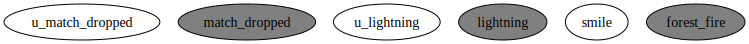

In [32]:
def forest_fire_model():
    u_match_dropped = pyro.sample("u_match_dropped", dist.Bernoulli(0.7))
    match_dropped = pyro.deterministic(
        "match_dropped", u_match_dropped, event_dim=0
    )  # notice uneven probs here

    u_lightning = pyro.sample("u_lightning", dist.Bernoulli(0.4))
    lightning = pyro.deterministic("lightning", u_lightning, event_dim=0)

    # this is a causally irrelevant site
    smile = pyro.sample("smile", dist.Bernoulli(0.5))

    forest_fire = pyro.deterministic(
        "forest_fire", torch.max(match_dropped, lightning) + (0 * smile), event_dim=0
    )

    return {
        "match_dropped": match_dropped,
        "lightning": lightning,
        "forest_fire": forest_fire,
    }

with ExtractSupports() as extract_supports:
    forest_fire_model()
    forest_fire_supports = {k: constraints.boolean for k in extract_supports.supports}

pyro.render_model(forest_fire_model)

In [101]:
query = SearchForExplanation(
    supports=forest_fire_supports,
    antecedents={"match_dropped": 1.0, "lightning": 1.0},
    consequents={"forest_fire": torch.tensor(1.0)},
    witnesses={},
    alternatives={"match_dropped": 0.0, "lightning": 0.0},
    consequent_scale=1e-5
)(forest_fire_model)

logp, trace, mwc, log_weight_vector = importance_infer(num_samples=10000)(query)()
print(torch.exp(logp))

tensor([-2.0027e-05, -1.1512e+01, -2.3024e+01,  ..., -2.0027e-05,
        -2.0027e-05, -2.0027e-05])
tensor(0.4743)


In [102]:
mask_intervened = trace.nodes["__cause____antecedent_match_dropped"]["value"] == 0
print(mask_intervened.float().sum())
print(mask_intervened)
print(log_weight_vector)
print(torch.exp(log_weight_vector) * mask_intervened.squeeze())

print(torch.sum(torch.exp(log_weight_vector) * mask_intervened.squeeze())/mask_intervened.float().sum())



tensor(4937.)
tensor([[[[[[[[[[ True]]]]]]]]],








        [[[[[[[[[False]]]]]]]]],








        [[[[[[[[[False]]]]]]]]],








        ...,








        [[[[[[[[[ True]]]]]]]]],








        [[[[[[[[[ True]]]]]]]]],








        [[[[[[[[[ True]]]]]]]]]])
tensor([-2.0027e-05, -1.1512e+01, -2.3024e+01,  ..., -2.0027e-05,
        -2.0027e-05, -2.0027e-05])
tensor([1.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000])
tensor(0.7991)


In [103]:
mask_intervened = trace.nodes["__cause____antecedent_lightning"]["value"] == 0
print(mask_intervened.float().sum())
print(mask_intervened)
print(log_weight_vector)
print(torch.exp(log_weight_vector) * mask_intervened.squeeze())

print(torch.sum(torch.exp(log_weight_vector) * mask_intervened.squeeze())/torch.sum(torch.exp(log_weight_vector)))

tensor(5130.)
tensor([[[[[[[[[[ True]]]]]]]]],








        [[[[[[[[[ True]]]]]]]]],








        [[[[[[[[[False]]]]]]]]],








        ...,








        [[[[[[[[[ True]]]]]]]]],








        [[[[[[[[[False]]]]]]]]],








        [[[[[[[[[ True]]]]]]]]]])
tensor([-2.0027e-05, -1.1512e+01, -2.3024e+01,  ..., -2.0027e-05,
        -2.0027e-05, -2.0027e-05])
tensor([9.9998e-01, 1.0013e-05, 0.0000e+00,  ..., 9.9998e-01, 0.0000e+00,
        9.9998e-01])
tensor(0.7025)


In [106]:
mask_intervened = (trace.nodes["__cause____antecedent_match_dropped"]["value"] == 1) & (trace.nodes["__cause____antecedent_lightning"]["value"] == 1)
print(mask_intervened.float().sum())
print(mask_intervened)
print(log_weight_vector)
print(torch.exp(log_weight_vector) * mask_intervened.squeeze())

print(torch.sum(torch.exp(log_weight_vector) * mask_intervened.squeeze())/mask_intervened.float().sum())

tensor(2467.)
tensor([[[[[[[[[[False]]]]]]]]],








        [[[[[[[[[False]]]]]]]]],








        [[[[[[[[[ True]]]]]]]]],








        ...,








        [[[[[[[[[False]]]]]]]]],








        [[[[[[[[[False]]]]]]]]],








        [[[[[[[[[False]]]]]]]]]])
tensor([-2.0027e-05, -1.1512e+01, -2.3024e+01,  ..., -2.0027e-05,
        -2.0027e-05, -2.0027e-05])
tensor([0.0000e+00, 0.0000e+00, 1.0014e-10,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00])
tensor(1.7309e-06)
